In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
from pathlib import Path
from sklearn import metrics

In [4]:
# Sets the video card to be used
torch.cuda.set_device(0)

In [5]:
PATH = Path("data/dog_and_cats_breeds")
list(PATH.iterdir())

[PosixPath('data/dog_and_cats_breeds/.ipynb_checkpoints'),
 PosixPath('data/dog_and_cats_breeds/train.csv'),
 PosixPath('data/dog_and_cats_breeds/test'),
 PosixPath('data/dog_and_cats_breeds/tmp'),
 PosixPath('data/dog_and_cats_breeds/train'),
 PosixPath('data/dog_and_cats_breeds/models')]

In [6]:
labels_csv = PATH/'train.csv'
n = len(list(open(labels_csv)))-1
n

7349

In [7]:
# Creates a random 15% of data for the validation set
val_idxs = get_cv_idxs(n, val_pct=0.15)
len(val_idxs)

1102

In [8]:
labels_df = pd.read_csv(PATH/'train.csv')
labels_df.head()

,id,breed
0,b0234bf14351b079397d8685b2907e8d,keeshond
1,378e20d6c6c2f08fb0d9dce02b22caf4,newfoundland
2,b900795a1441629688fcd8935def1e4e,great_pyrenees
3,a8d369de5c7ef297d19316a19ab24501,great_pyrenees
4,8bff692933224c78840b10d3c1c22a16,leonberger


In [9]:
# Sets the default parameters
sz = 223
arch = resnext101_64
bs = 64

### Inspecting the dataset

In [10]:
breeds_pt = labels_df.pivot_table(index='breed', aggfunc=len)

# Checking how many different breeds
len(breeds_pt)

37

<BarContainer object of 37 artists>

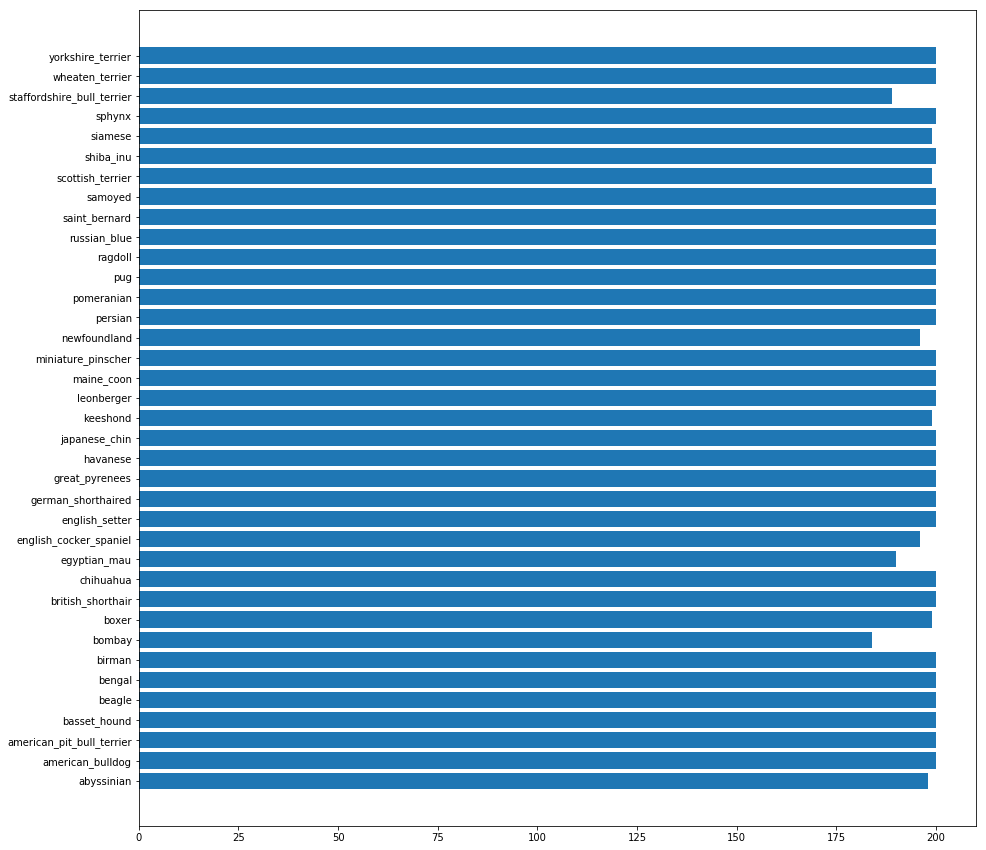

In [11]:
# Checking the distribution of breeds for class balance

fig, ax = plt.subplots(figsize=(15,15))
ax.barh(breeds_pt.index, breeds_pt['id'])

In [12]:
zoom = 1.1

In [13]:
# Sets the augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)

In [14]:
data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test', 
                                    tfms=tfms, bs=bs, suffix='.jpg', val_idxs=val_idxs, )

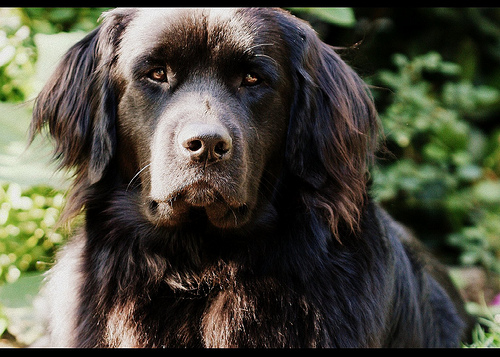

In [15]:
fn = PATH/data.trn_ds.fnames[1]
PIL.Image.open(fn)

In [16]:
len(data.trn_ds), len(data.test_ds), len(data.classes)

(6247, 6849, 37)

### Training the first model

In [17]:
def get_data(sz, bs, idxs):
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)
    data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test',
                                       val_idxs=idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data

In [18]:
data = get_data(sz, bs, val_idxs)

In [19]:
learn = ConvLearner.pretrained(arch, data, ps=0.6, precompute=True)

In [20]:
learn.lr_find()

 87%|████████▋ | 85/98 [00:00<00:00, 128.01it/s, loss=2.21]


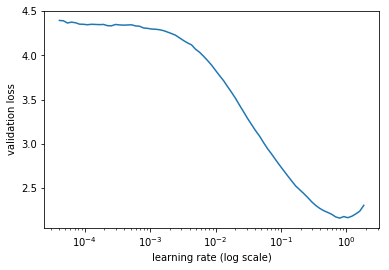

In [21]:
learn.sched.plot()

In [22]:
lr = 1e-2

In [23]:
learn.fit(lr, 8)

epoch      trn_loss   val_loss   accuracy                   
    0      0.779159   0.242974   0.928312  
    1      0.396603   0.185451   0.943739                   
    2      0.291635   0.164486   0.948276                   
    3      0.245694   0.151486   0.95735                    
    4      0.210877   0.155787   0.948276                   
    5      0.193444   0.150056   0.950091                   
    6      0.185445   0.151834   0.945554                   
    7      0.166055   0.140364   0.950091                   



[array([ 0.14036]), 0.95009074377710723]

In [24]:
# Turning precompute off allows data augmentation
learn.precompute = False

In [25]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.216692   0.137448   0.954628  
    1      0.212627   0.138469   0.953721                  
    2      0.203689   0.146771   0.953721                  
    3      0.199345   0.134742   0.951906                  
    4      0.191675   0.131409   0.956443                  



[array([ 0.13141]), 0.95644283089144477]

In [26]:
learn.save(f"dog_cats_{sz}")

In [27]:
learn.load(f"dog_cats_{sz}")

### Changing the size of the images to prevent overfitting

In [28]:
learn.set_data(get_data(299, bs, val_idxs))

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.196344   0.135192   0.950998  
    1      0.18746    0.137825   0.951906                  
    2      0.171241   0.133525   0.95735                   
    3      0.189375   0.131801   0.955535                  
    4      0.182579   0.129918   0.960073                  
    5      0.169235   0.130802   0.959165                  
    6      0.169795   0.13063    0.956443                  



[array([ 0.13063]), 0.95644283089144477]

In [30]:
learn.save(f"dog_cats_{sz}_2")

In [31]:
learn.load(f"dog_cats_{sz}_2")

### Final pass on entire training set

In [32]:
learn.set_data(get_data(299, bs, None))

In [33]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.169225   0.102063   0.967325  
    1      0.161108   0.100597   0.967325                  
    2      0.154815   0.103972   0.965283                  
    3      0.168054   0.107484   0.965283                  
    4      0.153048   0.099335   0.968005                  
    5      0.132694   0.09975    0.968005                  
    6      0.13189    0.100299   0.963921                  



[array([ 0.1003]), 0.96392103386542027]

In [34]:
learn.save(f"dog_cats_{sz}_3")

In [35]:
learn.load(f"dog_cats_{sz}_3")

### Fine tuning the frozen layers

In [36]:
# Doesn't seem to make an improvement for this dataset
# bs = 8
# learn.set_data(get_data(299, bs, val_idxs))

In [37]:
# learn.unfreeze()

In [38]:
# lr = np.array([1e-4, 1e-3, 1e-2])

In [39]:
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

### Performing TTA

In [40]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.97140912185159978, 0.096702940222187395)

### Confusion Matrix

In [41]:
preds = np.argmax(probs, axis=1)
probs = np.exp(log_preds)

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[43  0  0 ...,  0  0  0]
 [ 0 26  0 ...,  1  0  0]
 [ 0  3 26 ...,  3  0  0]
 ..., 
 [ 0  2  2 ..., 42  0  0]
 [ 0  0  0 ...,  0 43  0]
 [ 0  0  0 ...,  0  0 39]]


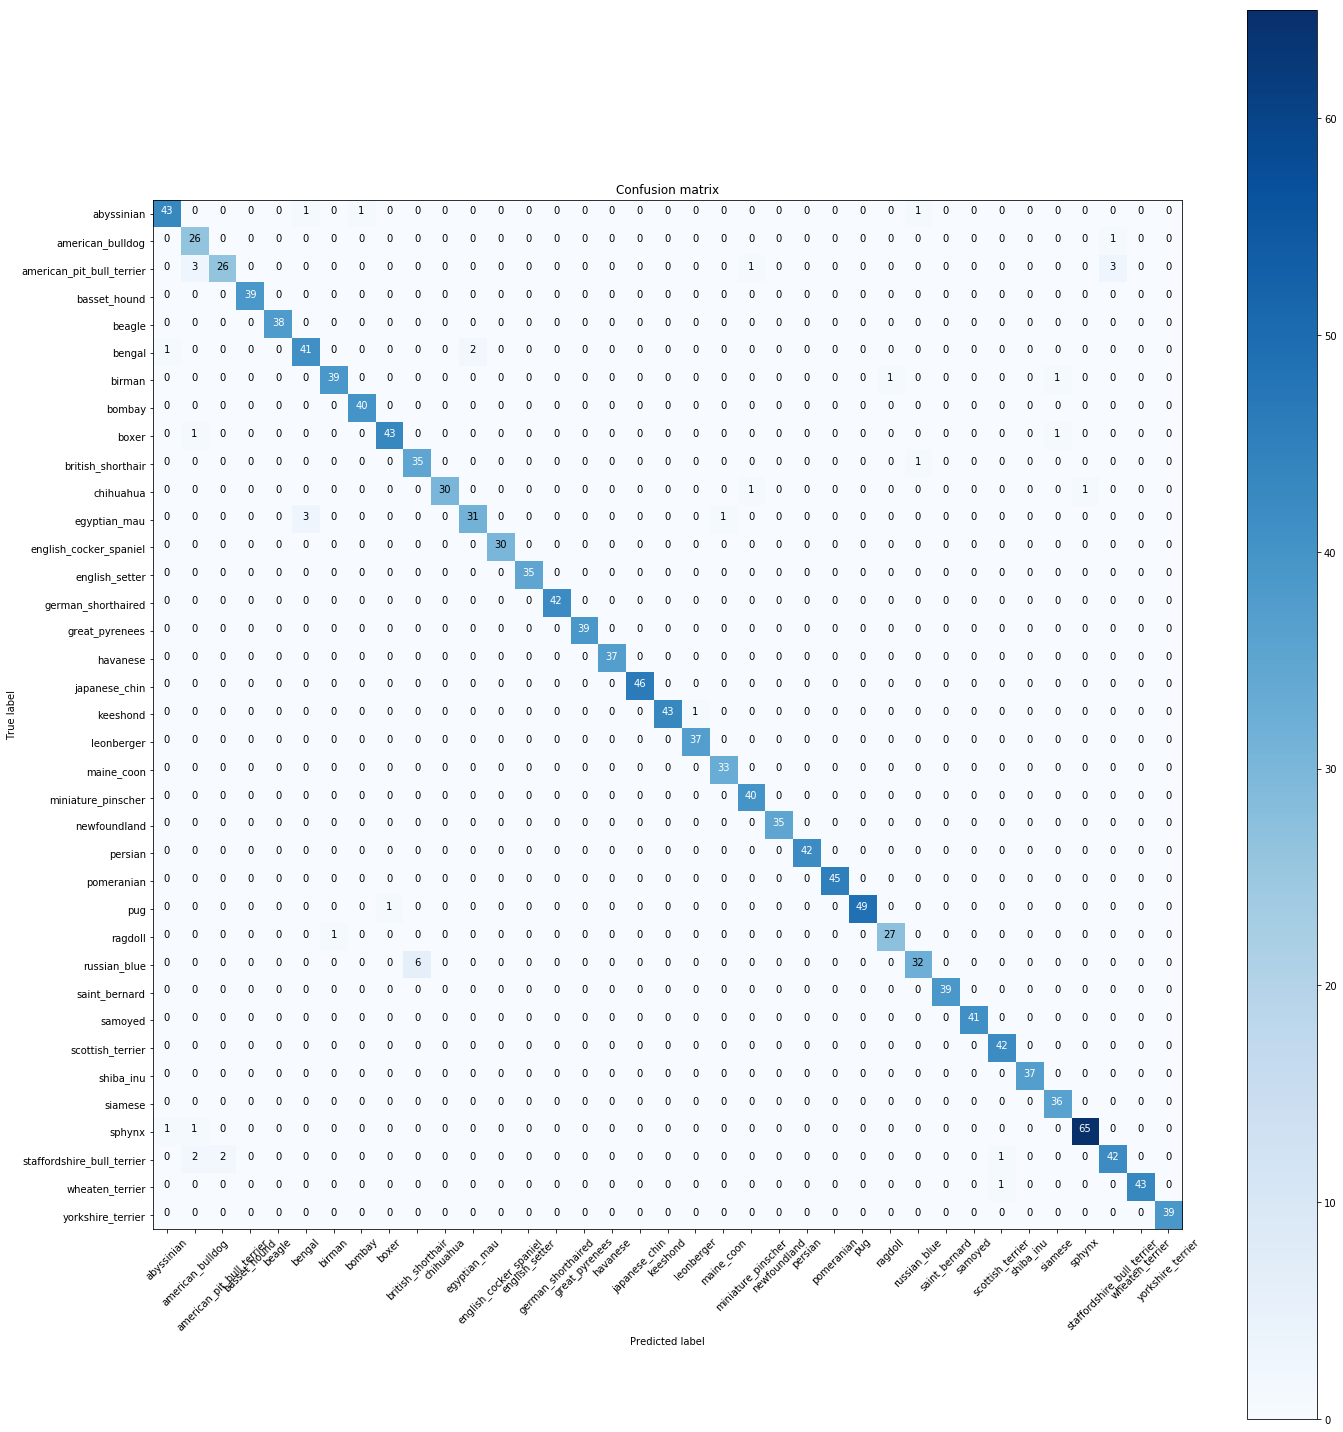

In [43]:
plot_confusion_matrix(cm, data.classes, figsize=(20,20))

### Submission

In [44]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [45]:
# Creates the dataframe with the classes as the column names
submit_df = pd.DataFrame(probs)
submit_df.columns = data.classes

In [46]:
# Inserts a column called 'id' of the picutre ids into the first column of the df
fnames = [names[5:-4] for names in data.test_ds.fnames]
submit_df.insert(0, 'id', fnames)

In [47]:
submit_df.head()

,id,abyssinian,american_bulldog,american_pit_bull_terrier,basset_hound,beagle,bengal,birman,bombay,boxer,...,russian_blue,saint_bernard,samoyed,scottish_terrier,shiba_inu,siamese,sphynx,staffordshire_bull_terrier,wheaten_terrier,yorkshire_terrier
0,bd848ac3c41863b4a393914068fdf3f6,1.307472e-07,7.111881e-04,0.985732,4.439744e-07,3.484143e-07,2.120145e-07,5.994447e-08,7.436467e-08,1.536117e-05,...,5.633248e-05,6.421834e-07,2.782397e-07,1.460888e-06,1.817519e-07,4.885371e-08,5.324916e-06,1.333123e-02,1.342618e-06,9.122564e-07
1,a44f09ed06a79d5cf8372e436e27456a,2.995928e-05,2.768853e-06,0.000046,1.810736e-06,3.338492e-05,4.503618e-07,4.159968e-06,9.921846e-01,1.035595e-04,...,1.199730e-03,3.980664e-07,1.418353e-06,3.484338e-05,6.744623e-06,5.398662e-05,1.765486e-05,2.287595e-03,9.462885e-06,6.343984e-06
2,dfdae801a41553251863569ab00dc403,7.657161e-03,3.956614e-05,0.001617,6.837261e-05,7.703464e-05,2.372154e-05,3.297552e-04,2.544065e-01,9.071400e-04,...,2.525781e-01,7.808326e-05,3.589096e-06,1.431318e-04,1.782484e-03,4.328795e-01,5.643682e-05,1.118969e-03,1.347435e-03,9.686754e-05
3,b3cf9bbe10527c7be747bde3c14a548e,8.453866e-03,3.126942e-07,0.000001,2.032195e-06,1.591974e-06,7.600418e-03,1.239724e-07,1.789684e-04,3.675232e-07,...,2.892439e-02,4.578955e-07,5.408931e-06,1.288060e-06,9.920879e-06,3.111570e-06,8.692128e-05,8.572243e-07,3.649357e-06,3.223469e-06
4,8bf3bb9b54053772254e8d3801bc7e61,1.320577e-08,1.211049e-04,0.960546,9.373706e-08,7.115065e-08,7.802188e-09,1.070111e-08,1.080688e-08,3.952118e-06,...,9.743283e-07,3.652564e-08,5.878576e-08,2.807107e-07,7.208851e-08,1.621531e-08,2.753885e-07,3.931532e-02,8.778933e-08,4.550992e-07


In [48]:
submit_df.to_csv('subm', index=False)